In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import glob

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import scipy.interpolate

# dLux imports
import dLux as dl
import dLux.utils as dlu


%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

In [70]:
files = glob.glob("../batch/timeseries-orbit/*.npz")
files.sort()
files = [f for f in files if ("/8." not in f) and ("/11." not in f) ]#[5:6]
print(len(files))

18


In [71]:
defocuses = []
errs = []
mjds = []
fluxes = []
mjd_start = []
aberrations=[]
pams=[]
for file in files:
    with np.load(file) as res:
        #print(res)
        #print(len(res["defocuses"]))
        #print(res["cold_shift"])
        defocus = res["defocuses"]
        err = res["errs"]
        mjd_sec = res["mjds"]#*24*60 
        flux = res["spectra"]
        aberration = res["aberrations"]
        pam = res["pams"]
        if (np.max(mjd_sec)-np.min(mjd_sec))<1.:
            mjd_sec *= 24*60

        mjd_start.append(mjd_sec[0]/24/60)

        mjd_sec -= mjd_sec[0]
        

        mask = np.logical_and(np.logical_and(defocus < 200, defocus > 100), np.squeeze(np.abs(err)<10))#.flatten()
        #print(mask)
        #print(np.abs(defocus) < 500)
        #defocuses = defocuses + (list(defocus[mask]))
        #errs = errs + list(err[mask])
        #mjds = mjds + list(mjd_sec[mask])
        defocuses.append(list(defocus[mask]))
        errs.append(list(err[mask].flatten()))
        mjds.append(list(mjd_sec[mask]))
        fluxes.append(list(flux[mask].flatten()))
        aberrations.append(aberration[mask])
        pams.append(pam[mask])
        print(len(defocuses[-1]))
        

198
211
211
236
247
247
247
197
184
181
260
208
212
211
241
241
229
211


In [72]:
files[-2]

'../batch/timeseries-orbit/7.npz'

In [73]:
aberrations[0].shape

(198, 12)

In [74]:
np.concat((aberrations[0], aberrations[1])).shape

(409, 12)

In [75]:
len(defocuses)

18

In [76]:
order = np.argsort(np.asarray(mjd_start))[3:]

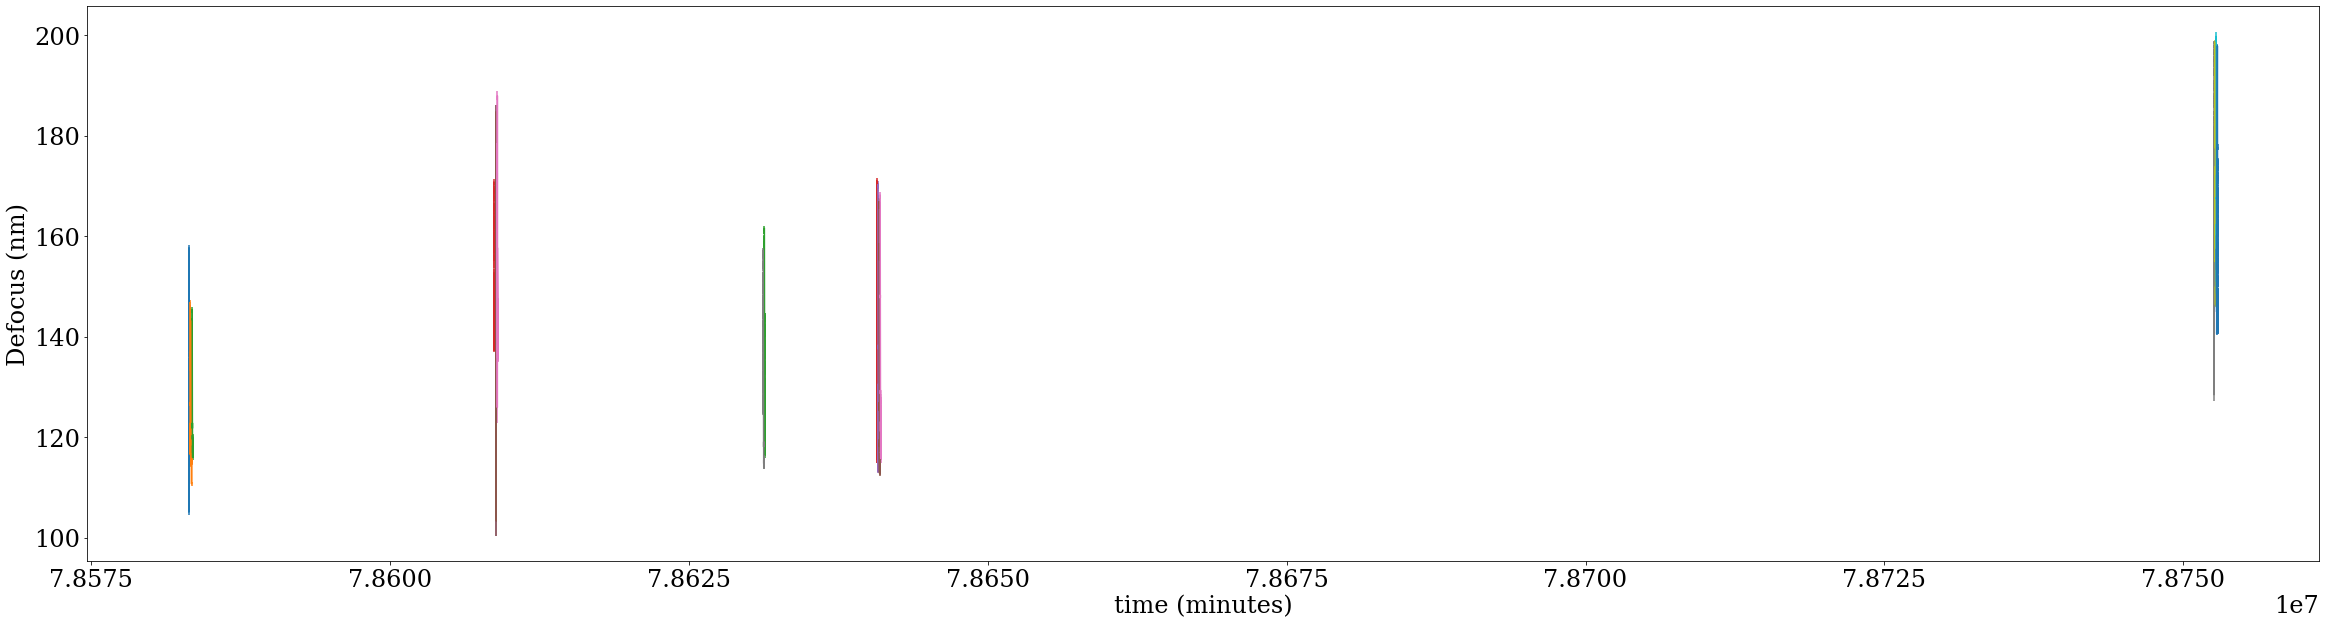

In [77]:
#plt.errorbar(mjds, defocuses, np.squeeze(np.abs(errs)))
plt.figure(figsize=(40,10))
nexps = 0
for i in range(len(defocuses)):
    if True:#(mjd_start[i]*60*24 > 7.860e7) and (mjd_start[i]*60*24 < 7.862e7):
        #plt.scatter(mjds[i]+mjd_start[i]*60*24,defocuses[i])
        plt.errorbar(np.asarray(mjds[i])+mjd_start[i]*60*24, np.asarray(defocuses[i]), np.abs(np.asarray(errs[i]).flatten()))
        plt.xlabel("time (minutes)")
        plt.ylabel("Defocus (nm)")
        nexps += len(defocuses[i])
plt.show()

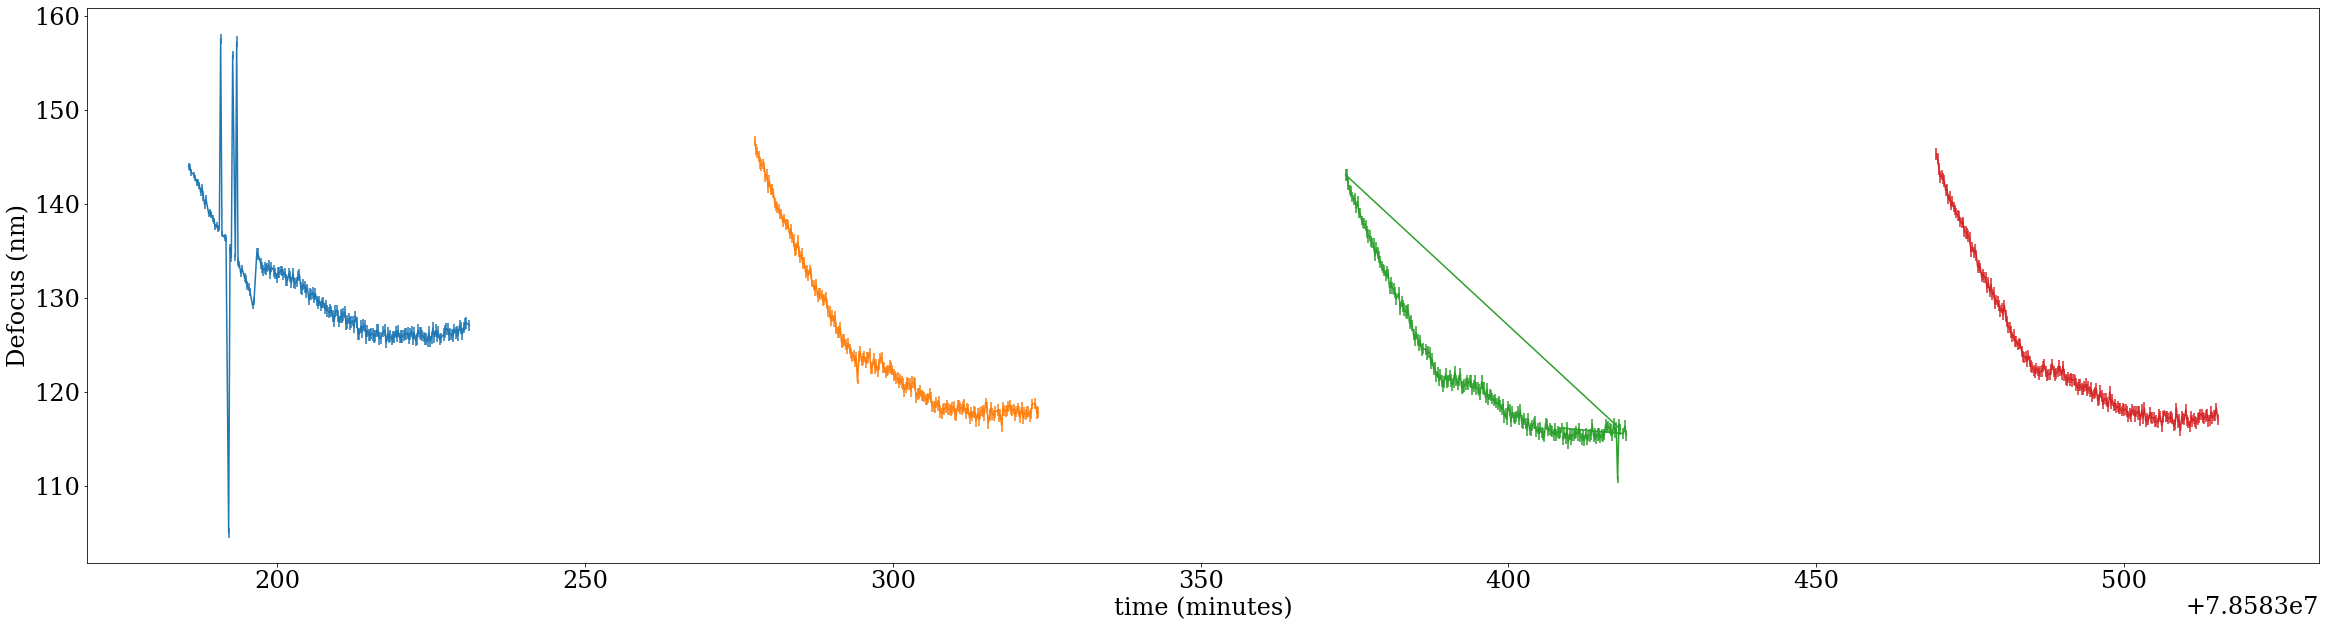

In [78]:
#plt.errorbar(mjds, defocuses, np.squeeze(np.abs(errs)))
plt.figure(figsize=(40,10))
nexps = 0
for i in range(len(defocuses)):
    if (mjd_start[i]*60*24 < 7.860e7):
    #if (mjd_start[i]*60*24 > 7.860e7) and (mjd_start[i]*60*24 < 7.862e7):
        #plt.scatter(mjds[i]+mjd_start[i]*60*24,defocuses[i])
        plt.errorbar(np.asarray(mjds[i])+mjd_start[i]*60*24, np.asarray(defocuses[i]), np.abs(np.asarray(errs[i]).flatten()))
        plt.xlabel("time (minutes)")
        plt.ylabel("Defocus (nm)")
        nexps += len(defocuses[i])
plt.show()

In [79]:
errs

[[np.float32(0.35836446),
  np.float32(0.34534854),
  np.float32(0.33855265),
  np.float32(0.3401827),
  np.float32(0.36237714),
  np.float32(0.35613507),
  np.float32(0.3673775),
  np.float32(0.36441827),
  np.float32(0.45305505),
  np.float32(0.40693173),
  np.float32(0.50173104),
  np.float32(0.43285352),
  np.float32(0.4806865),
  np.float32(0.3593303),
  np.float32(0.3366341),
  np.float32(0.33893934),
  np.float32(0.33453453),
  np.float32(0.30567056),
  np.float32(0.30830884),
  np.float32(0.30473804),
  np.float32(0.3094854),
  np.float32(0.28182),
  np.float32(0.5727407),
  np.float32(0.30648974),
  np.float32(0.3470541),
  np.float32(0.3403979),
  np.float32(0.5300325),
  np.float32(0.37337568),
  np.float32(0.41163865),
  np.float32(0.45843345),
  np.float32(0.42593908),
  np.float32(0.5876944),
  np.float32(0.3996079),
  np.float32(0.3980278),
  np.float32(0.40465173),
  np.float32(0.39868632),
  np.float32(0.46715593),
  np.float32(0.46285954),
  np.float32(0.475001),
  np

In [80]:
all_mjds = np.concat([mjds[i] + mjd_start[i]*60*24 for i in range(len(mjds))])
all_defocuses = np.concat(defocuses)
all_errs = np.concat(errs)
all_fluxes = np.concat(fluxes)

all_aberrations = np.concat(aberrations)
all_pams = np.concat(pams)


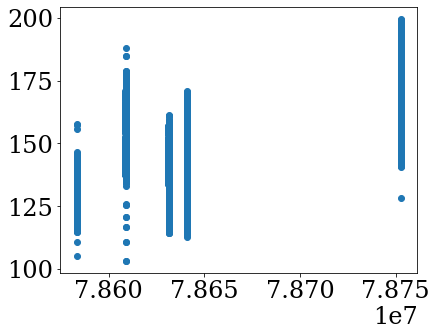

In [81]:
plt.scatter(all_mjds, all_defocuses)

In [82]:
kmeans = KMeans(n_clusters=5, random_state=0)
#kmeans = DBSCAN(eps=0.001, min_samples=10)
clumps = kmeans.fit_predict(np.reshape(all_mjds, (-1, 1)))

In [83]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(np.reshape(all_mjds, (-1, 1)))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(5)

clumps = lut[kmeans.labels_]


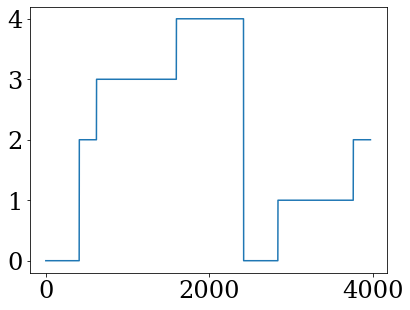

In [84]:
plt.plot(clumps)

3972


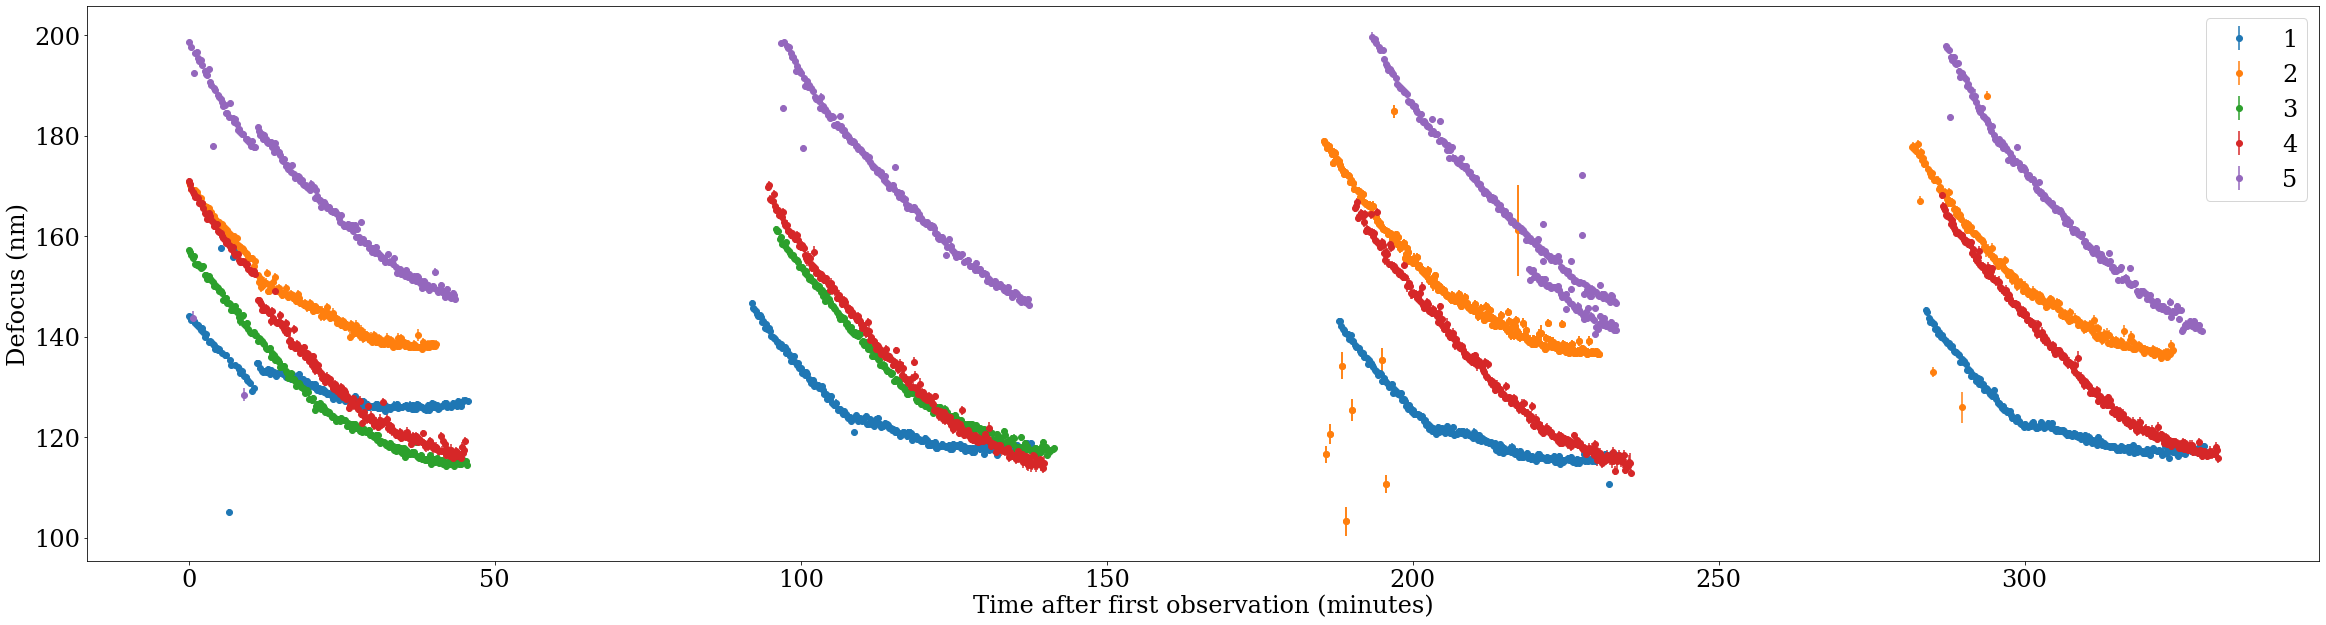

In [85]:
plt.figure(figsize=(40,10))
plt.xlabel("Time after first observation (minutes)")
plt.ylabel("Defocus (nm)")
num_points = 0
for i in range(5):#[0,2,3,4]:
    num_points += np.sum(clumps==i)
    plt.errorbar(all_mjds[clumps==i]-np.min(all_mjds[clumps==i]), all_defocuses[clumps==i], yerr = np.abs(all_errs[clumps==i].flatten()), fmt = 'o')
#plt.legend(['Visit 1 (15/04/2008 F187N)', 'Visit 2 (03/05/2008 F166N)', 'Visit 3 (18/05/2008 F187N)', 'Visit 4 (28/05/2008 F166N)', 'Visit 5 (11/08/2008 F187N)'])
plt.legend(['1','2', '3', '4', '5'])
print(num_points)

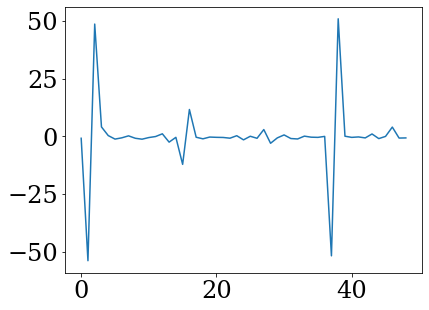

In [86]:
plt.plot(np.diff(all_defocuses[clumps==4][:50]))

3972


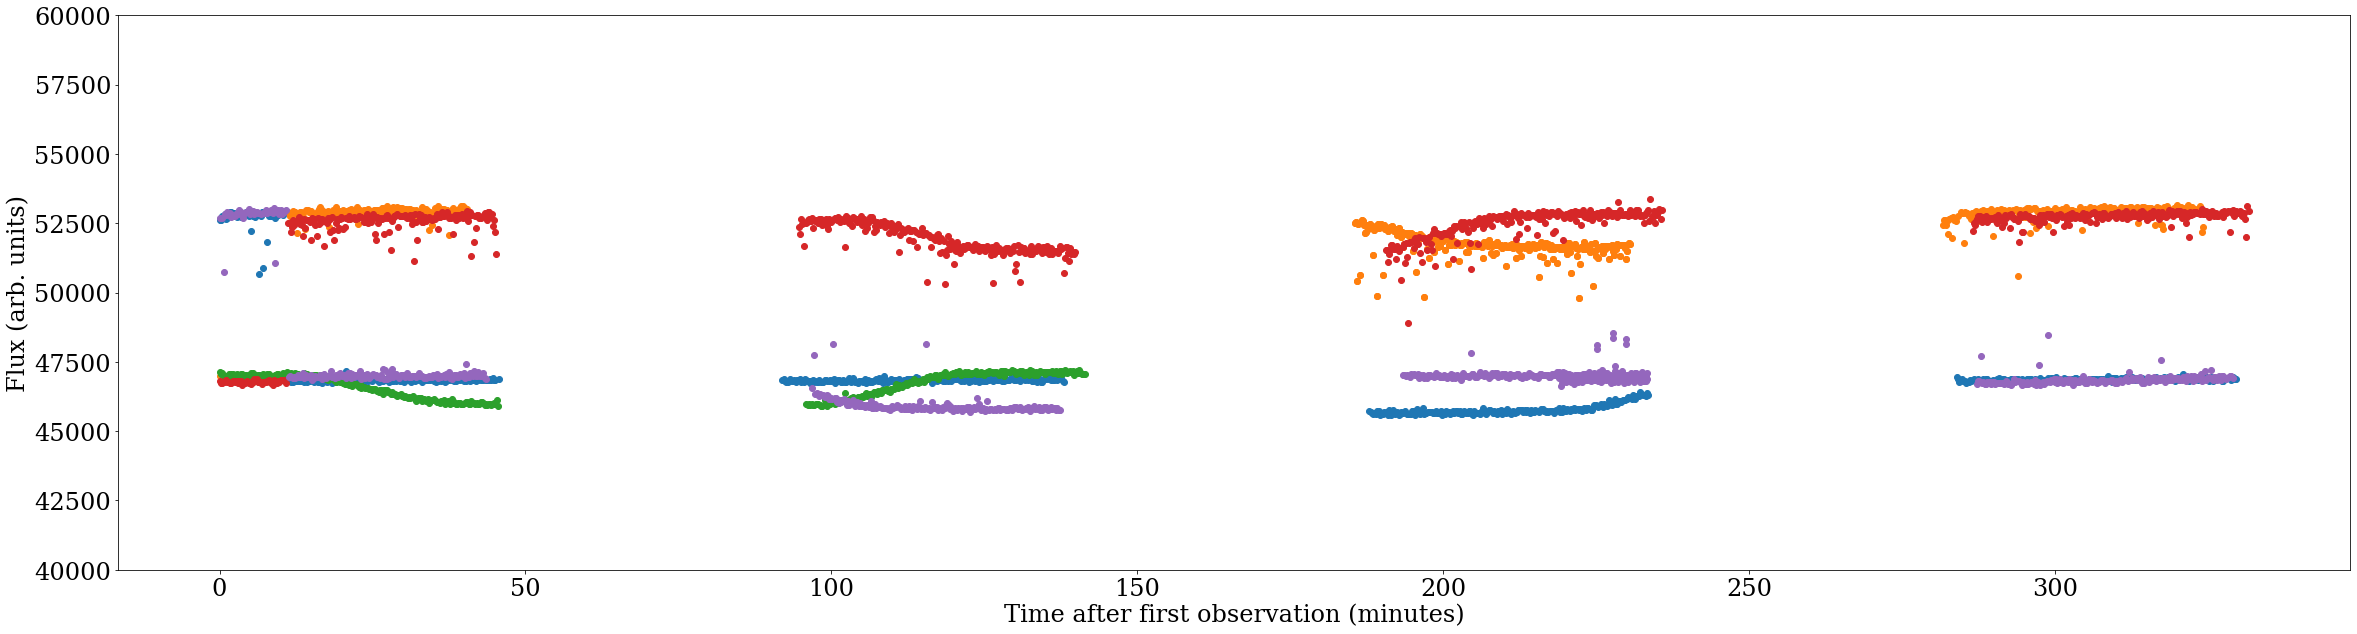

In [87]:
plt.figure(figsize=(40,10))
plt.xlabel("Time after first observation (minutes)")
plt.ylabel("Flux (arb. units)")
plt.ylim((40000, 60000))
#plt.ylabel("Defocus (nm)")
num_points = 0
for i in range(5):#[0,2,3,4]:
    num_points += np.sum(clumps==i)
    plt.scatter(all_mjds[clumps==i]-np.min(all_mjds[clumps==i]), 10**all_fluxes[clumps==i])
print(num_points)

822


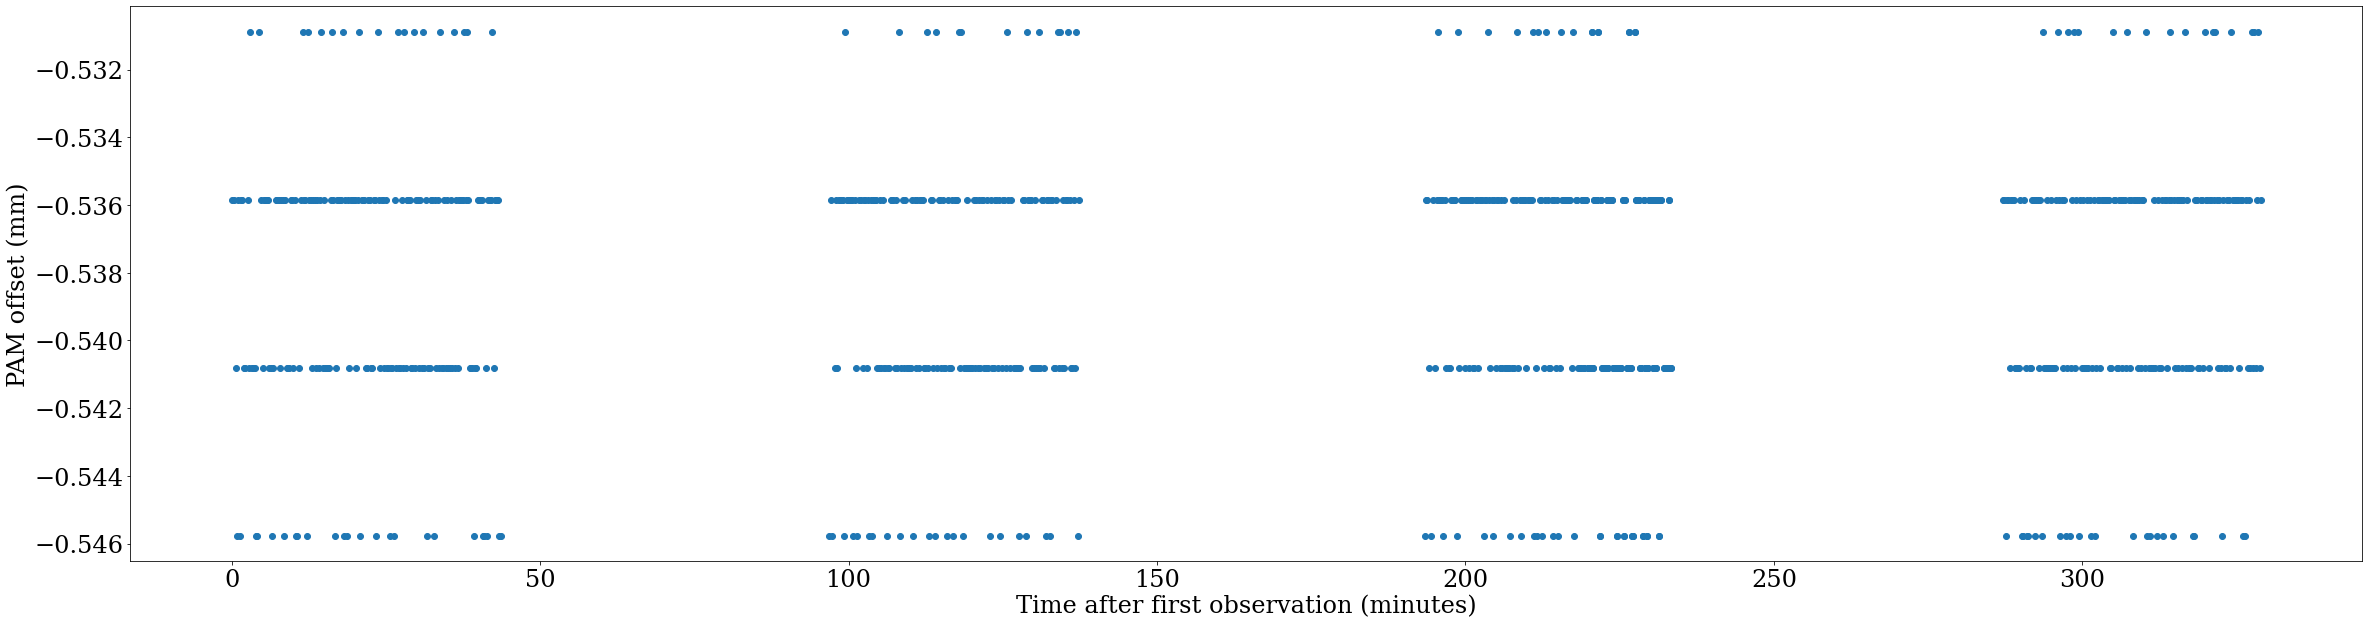

In [88]:
plt.figure(figsize=(40,10))
plt.xlabel("Time after first observation (minutes)")
plt.ylabel("PAM offset (mm)")
#plt.ylim((40000, 60000))
#plt.ylabel("Defocus (nm)")
num_points = 0
for i in [4]:#[0,2,3,4]:
    num_points += np.sum(clumps==i)
    plt.scatter(all_mjds[clumps==i]-np.min(all_mjds[clumps==i]), all_pams[clumps==i])
print(num_points)

In [89]:
mjds_files = np.load("../batch/mjds.npy")

In [90]:
kmeans = KMeans(n_clusters=20, random_state=1).fit(np.reshape(mjds_files, (-1, 1)))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(20)

mjd_clumps = lut[kmeans.labels_]


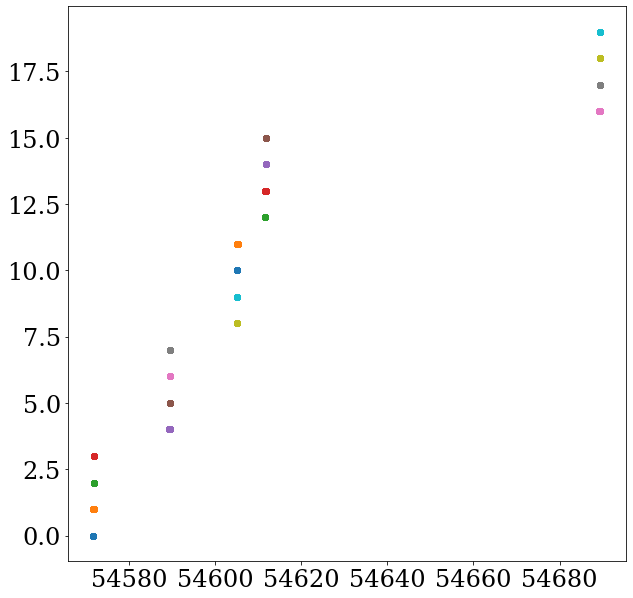

In [91]:
plt.figure(figsize=(10,10))
for i in range(20):
#for i in [3,9,12,19]:
#for i in [0,6,16,17]:

    plt.scatter(mjds_files[mjd_clumps == i], mjd_clumps[mjd_clumps==i])

In [92]:
pca = PCA(n_components=5)
pca.fit(all_aberrations)
print(pca.singular_values_)
print(pca.components_)
print(pca.explained_variance_)
components = pca.components_

[1284.9152   662.8996   321.86588  257.4997   173.60385]
[[ 0.9585204   0.08117184  0.1519194  -0.03056115 -0.07784947 -0.00828836
   0.05267912  0.14704143 -0.04125292 -0.07124753 -0.00758252  0.11521804]
 [-0.133734   -0.05758449  0.8593278   0.04787383  0.30680653  0.28533322
  -0.02166087 -0.01270586 -0.0976723  -0.1653952   0.04251094  0.15226468]
 [-0.20663689 -0.15006411  0.02858253 -0.37249652 -0.3990323  -0.05775365
   0.11373162  0.65001386 -0.21302557 -0.23335925 -0.00659611  0.31195548]
 [ 0.01326677  0.26326865 -0.26410693 -0.1507957   0.7422011   0.08040363
  -0.20135787  0.47639015 -0.05735297 -0.04308603 -0.07559045 -0.04839752]
 [-0.09383265  0.7419283  -0.10040475  0.1104288  -0.13653047  0.2562013
   0.27510226 -0.17292103 -0.38554972 -0.03925692 -0.05365294  0.2748296 ]]
[415.76608  110.661255  26.08855   16.69758    7.589599]


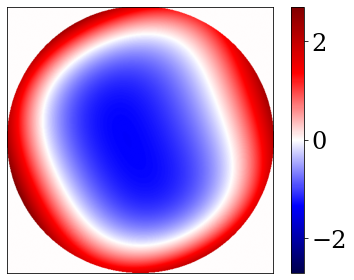

In [93]:
ap = dl.AberratedAperture(dl.CircularAperture(radius=1.2), noll_inds=np.arange(4,4+12), coefficients=components[0])
coords = dlu.pixel_coords(512, 2.4)

opd = ap.eval_basis(coords)#*1e9
m = np.max(np.abs(opd))
plt.imshow(opd, cmap='seismic', vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.colorbar()


[108.371056  42.220627  24.710539  16.150059  10.400213]
[[ 7.31994331e-01  2.13266984e-02 -6.09464467e-01 -4.13594469e-02
   1.37189984e-01 -1.74621344e-01 -1.03832148e-01  1.46632746e-01
   3.80613208e-02  7.96923265e-02 -9.11784265e-03 -3.30651999e-02]
 [ 6.77329004e-01  1.58699639e-02  6.87005579e-01  6.65520057e-02
  -1.37805611e-01  1.35403901e-01  9.21654776e-02 -1.21504344e-01
  -1.33912684e-02 -4.02222686e-02  4.25562821e-02  1.94191597e-02]
 [ 5.05426228e-02  2.48938873e-01 -2.72641510e-01 -3.26438844e-02
   1.67272985e-01  5.35485625e-01  3.54263961e-01 -5.14018834e-01
  -3.04428041e-01 -2.10614637e-01 -1.36371061e-01 -6.50759903e-04]
 [-4.63710763e-02  8.44668448e-01  1.33393437e-01  8.15474764e-02
   2.96764225e-01 -2.02290714e-03  2.75172163e-02  3.23317021e-01
   8.90158210e-03  1.64118707e-01  1.74506471e-01 -9.54477564e-02]
 [ 2.11213380e-02 -2.15557277e-01  7.35653415e-02 -5.14347017e-01
   1.61534682e-01  3.49574566e-01  1.77967221e-01  6.44591987e-01
  -1.85373038e-

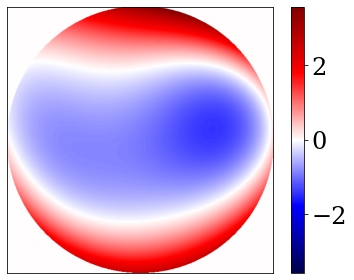

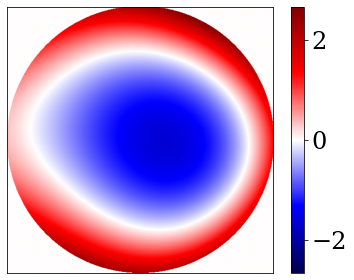

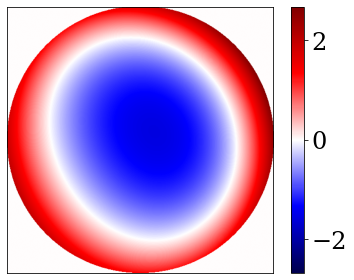

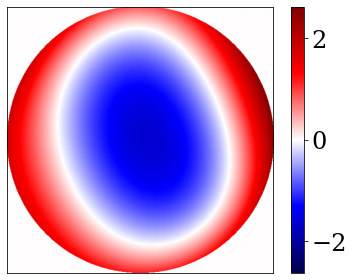

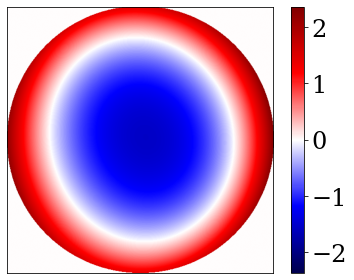

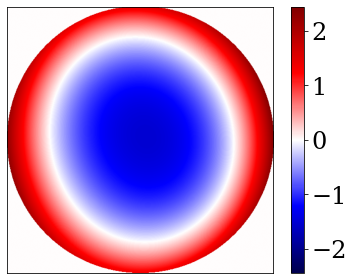

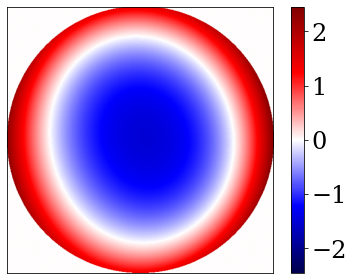

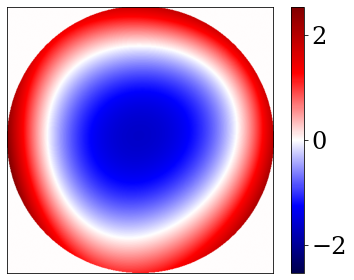

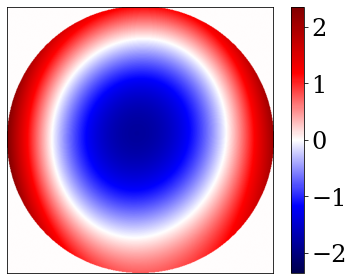

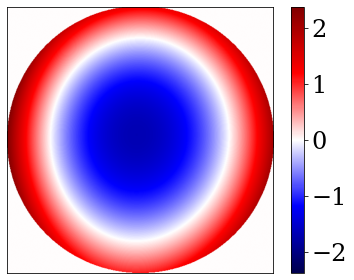

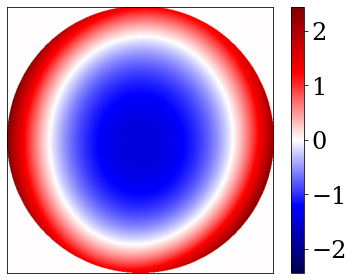

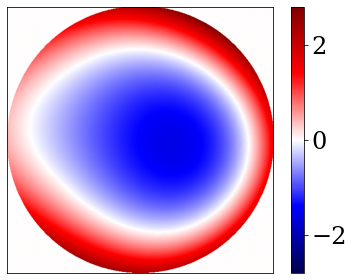

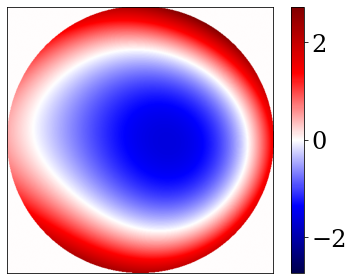

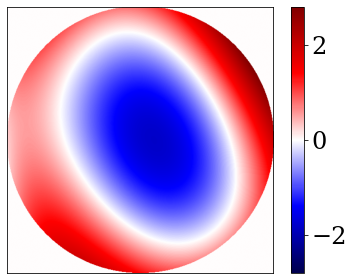

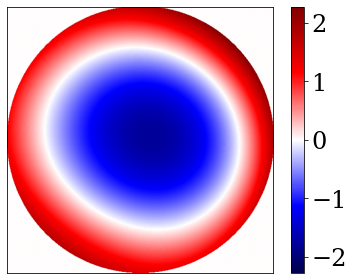

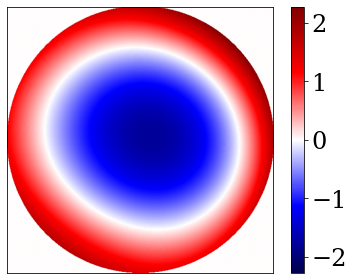

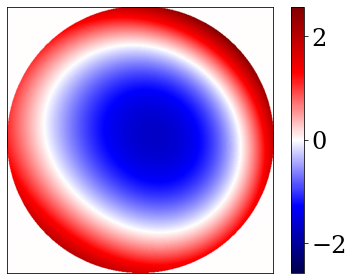

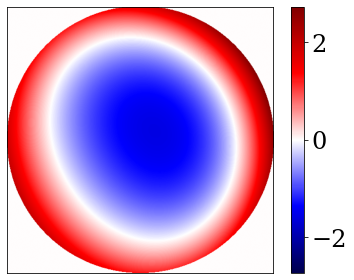

In [94]:
for i in range(20):
    try:
        pca = PCA(n_components=5)
        pca.fit(aberrations[i])
        print(pca.singular_values_)
        print(pca.components_)
        print(pca.explained_variance_)
        components = pca.components_
        ap = dl.AberratedAperture(dl.CircularAperture(radius=1.2), noll_inds=np.arange(4,4+12), coefficients=components[0])
        coords = dlu.pixel_coords(512, 2.4)

        opd = ap.eval_basis(coords)#*1e9
        m = np.max(np.abs(opd))
        plt.figure()
        plt.imshow(opd, cmap='seismic', vmin=-m, vmax=m)
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
    except Exception:
        pass

In [95]:
162/5

32.4

In [96]:
# smoothing for orbits
kmeans = KMeans(n_clusters=18, random_state=0).fit(np.reshape(all_mjds, (-1, 1)))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(18)

clumps_i = lut[kmeans.labels_]



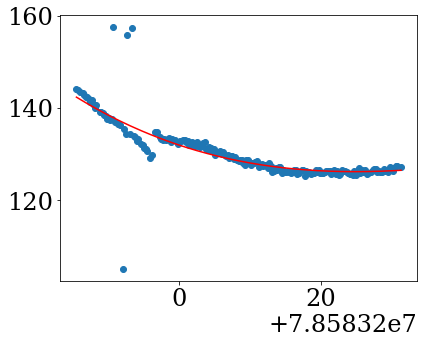

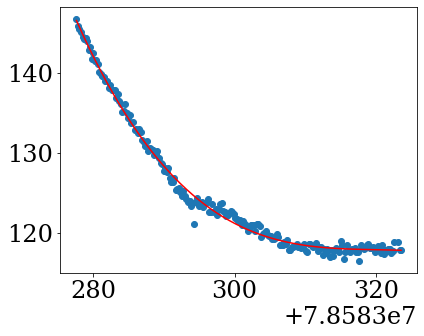

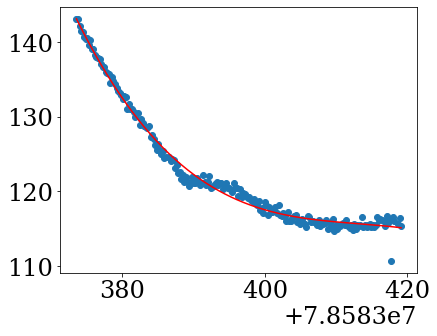

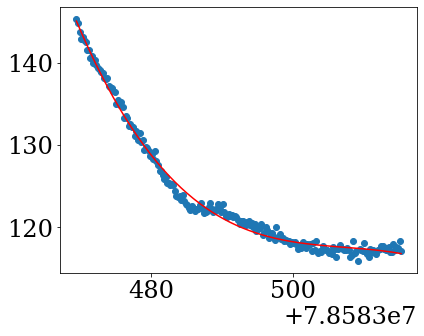

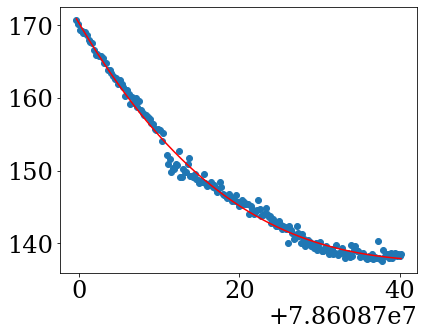

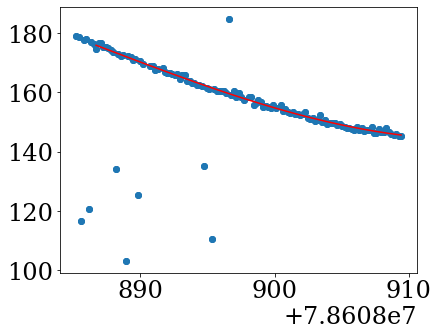

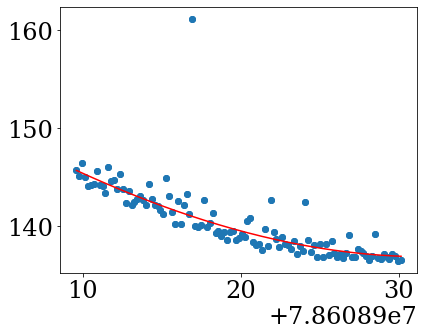

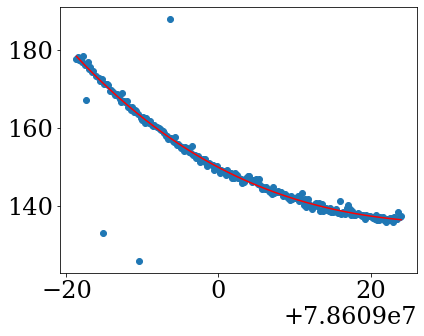

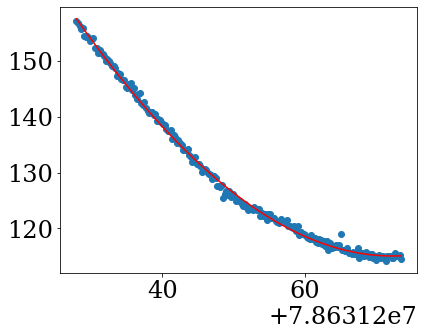

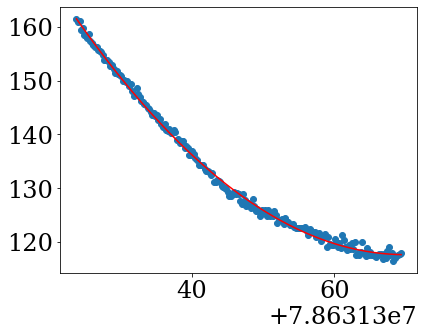

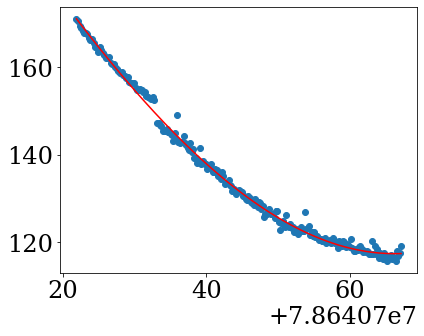

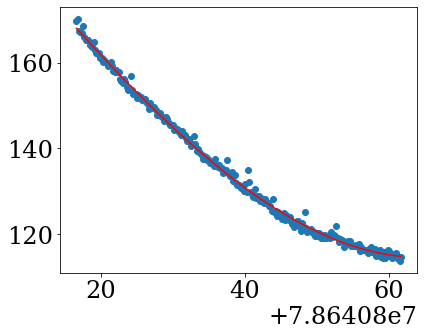

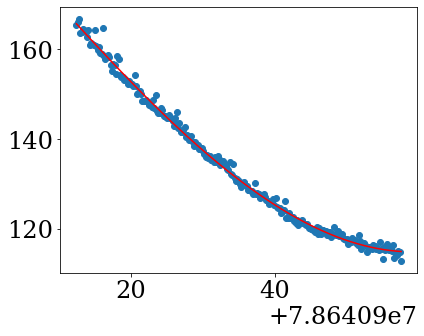

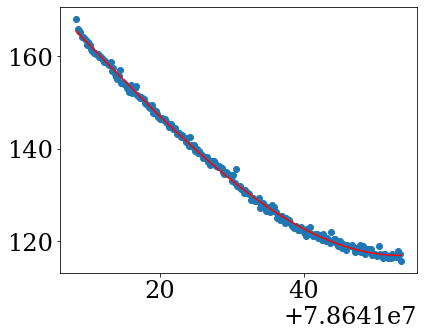

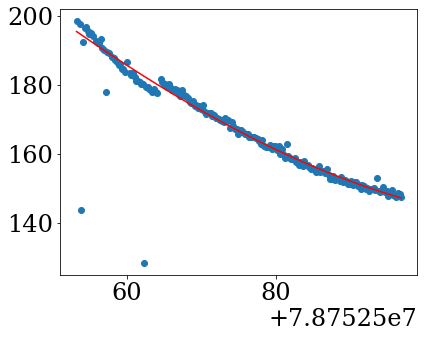

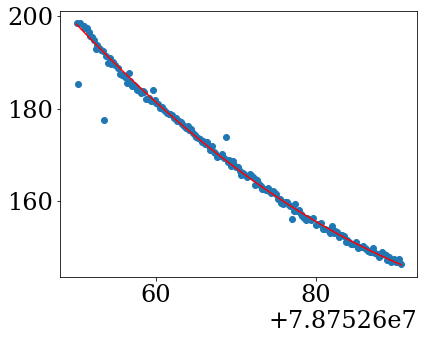

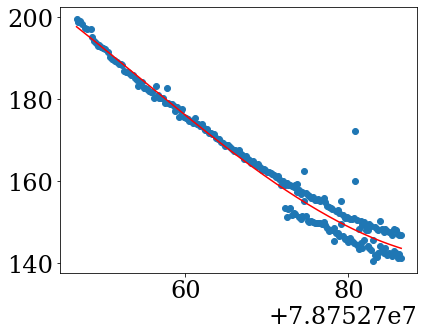

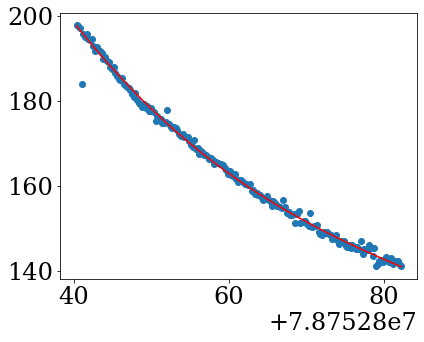

In [ ]:
splines = []
for i in range(18):
    plt.figure()
    order = np.argsort(all_mjds[clumps_i==i])
    x = all_mjds[clumps_i==i][order]#-np.min(all_mjds[clumps_i==i][order])
    y = all_defocuses[clumps_i==i][order]
    plt.scatter(x, y)
    interp = scipy.interpolate.BSpline(*scipy.interpolate.splrep(x, y ,s=1e7))#5500))

    good = np.abs(y - interp(x)) < 10
    x2 = x = all_mjds[clumps_i==i][order][good]#-np.min(all_mjds[clumps_i==i][order][good])
    y2 = all_defocuses[clumps_i==i][order][good]
    interp2 = scipy.interpolate.BSpline(*scipy.interpolate.splrep(x2, y2 ,s=1e7))#5500))
    splines.append(interp2)
    plt.plot(x,interp2(x), color='red')

splines.insert(8, None)
splines.insert(11, None)

np.save("splines.npy", splines, allow_pickle=True)


In [105]:
splines[9]